# NFA prediction

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

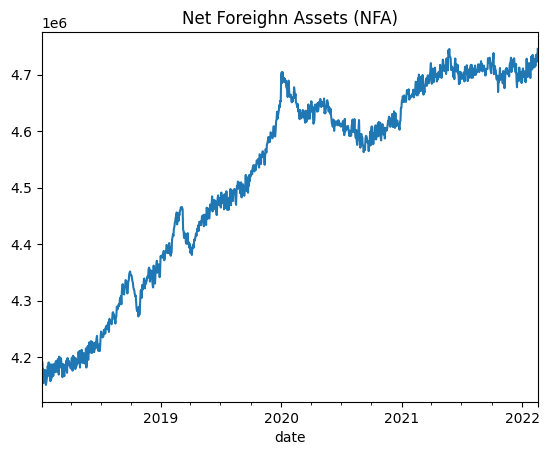

In [3]:
data = pd.read_excel('../data/NFA.xlsx', parse_dates=['date'], index_col='date')
data['break'] = 0
data.loc['2020-01-06':, 'break'] = 1
data['NFA'].plot(title = 'Net Foreighn Assets (NFA)'); plt.show()

## Section 2: Model Definition

In [4]:
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.statsforecast import (
    StatsForecastAutoARIMA,
    StatsForecastAutoETS,
    StatsForecastAutoCES, 
    StatsForecastAutoTheta,
    StatsForecastMSTL,
    StatsForecastAutoTBATS,
)
from sktime.forecasting.arch import StatsForecastGARCH
from sktime.forecasting.fbprophet import Prophet

ForecastingModels = {
    "Naive": NaiveForecaster(),
    "Seasonal_Naive": NaiveForecaster(sp = 5),
    "AutoARIMA": StatsForecastAutoARIMA(
                    trend=True, seasonal=True,
                    max_D = 5, max_p= 10, max_q=10),
    "AutoETS": StatsForecastAutoETS(season_length=5),
    "AutoCES": StatsForecastAutoCES(season_length=5),
    "AutoTheta": StatsForecastAutoTheta(season_length=5),
    "AutoTBATS": StatsForecastAutoTBATS(seasonal_periods=5, use_trend =True, use_boxcox=True),
    "LOESS": StatsForecastMSTL(season_length=5),
    "Prophet": Prophet(yearly_seasonality=True, weekly_seasonality=True),
}
from forecast_combine import model_select as f
model = f.ForecastModelSelect(
            data= data,
            depvar_str = 'NFA',                 
            #exog_l=['break'],
            fh = 10,
            pct_initial_window=0.75,
            step_length = 5,
            forecasters_d= ForecastingModels,
            freq = 'B',
            mode = 'best_horizon',
            score = 'RMSE', 
            nbest = 2)

### Cross validation Procedure

Number of Folds      : 53
Initial Window Size  : 808
Step Length          : 5
Forecast Horizon     : 10
First Cutoff         : 2021-02-05 00:00:00
Last Curoff          : 2022-02-04 00:00:00


<Axes: title={'center': 'Cross Validation Procedure'}, ylabel='Window number'>

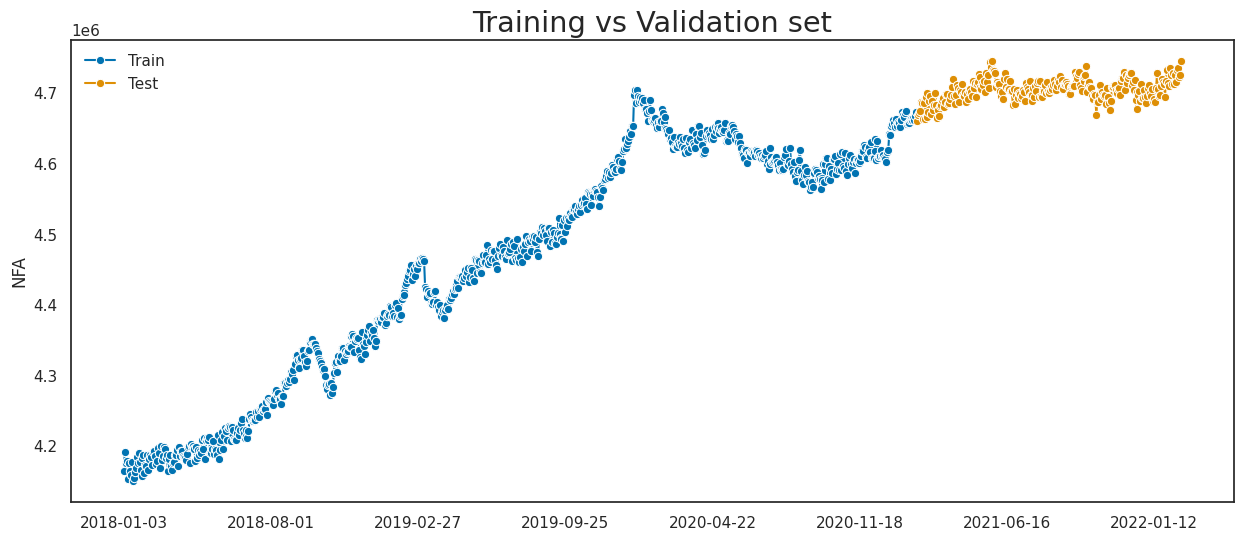

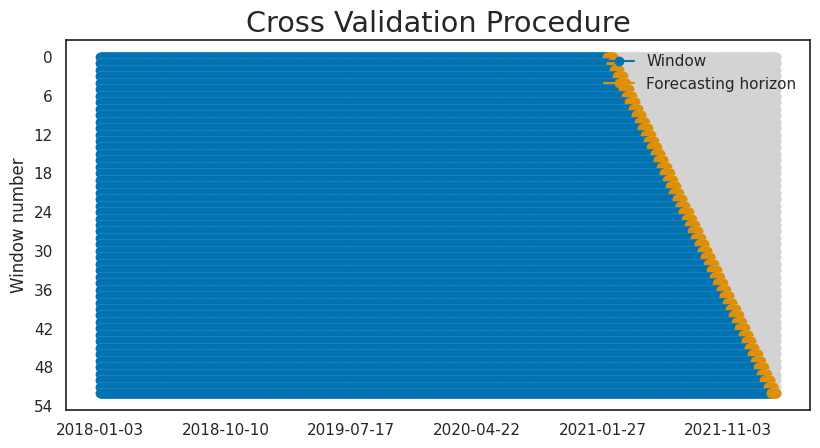

In [5]:
_ = model.split_procedure_summary()

model.plot_train_test(
    labels = ['Train', 'Test'],
    title='Training vs Validation set')

model.plot_cv_procedure(xlabel='')

### Out-Of-sample Evaluation

In [6]:
summary_horizon, summary_results = model.evaluate()


Start Naive forecaster evalution....
Evaluation completed in: 0.077 minutes

Start Seasonal_Naive forecaster evalution....
Evaluation completed in: 0.048 minutes

Start AutoARIMA forecaster evalution....


/home/ubuntu/Documents/Projects/forecast/.venv/lib/python3.9/site-packages/statsforecast/arima.py:913: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
/home/ubuntu/Documents/Projects/forecast/.venv/lib/python3.9/site-packages/statsforecast/arima.py:913: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
/home/ubuntu/Documents/Projects/forecast/.venv/lib/python3.9/site-packages/statsforecast/arima.py:913: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
/home/ubuntu/Documents/Projects/forecast/.venv/lib/python3.9/site-packages/statsforecast/arima.py:913: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
/home/ubuntu/Documents/Projects/forecast/.venv/lib/python3.9/site-packages/statsforecast/arima.py:913: UserWarning: possible convergence problem: minimize gave code 1]
  warnings.warn(
/home/ubuntu/Documents/Projects/forecast/.venv/lib/python3.9/site-packages/

Evaluation completed in: 0.708 minutes

Start AutoETS forecaster evalution....
Evaluation completed in: 1.185 minutes

Start AutoCES forecaster evalution....
Evaluation completed in: 1.329 minutes

Start AutoTheta forecaster evalution....
Evaluation completed in: 0.776 minutes

Start AutoTBATS forecaster evalution....


/home/ubuntu/Documents/Projects/forecast/.venv/lib/python3.9/site-packages/statsforecast/utils.py:356: FutureWarning: `seasonal_periods` has been deprecated, please use `season_length` instead.
  warnings.warn(
/home/ubuntu/Documents/Projects/forecast/.venv/lib/python3.9/site-packages/statsforecast/utils.py:356: FutureWarning: `seasonal_periods` has been deprecated, please use `season_length` instead.
  warnings.warn(
/home/ubuntu/Documents/Projects/forecast/.venv/lib/python3.9/site-packages/statsforecast/utils.py:356: FutureWarning: `seasonal_periods` has been deprecated, please use `season_length` instead.
  warnings.warn(
/home/ubuntu/Documents/Projects/forecast/.venv/lib/python3.9/site-packages/statsforecast/utils.py:356: FutureWarning: `seasonal_periods` has been deprecated, please use `season_length` instead.
  warnings.warn(
/home/ubuntu/Documents/Projects/forecast/.venv/lib/python3.9/site-packages/statsforecast/utils.py:356: FutureWarning: `seasonal_periods` has been deprecated

Evaluation completed in: 0.973 minutes

Start LOESS forecaster evalution....
Evaluation completed in: 0.484 minutes

Start Prophet forecaster evalution....
Evaluation completed in: 0.179 minutes


In [7]:
display(summary_results.T.sort_values('Avg MAPE'))
display(summary_horizon.T)

,Number of Folds,Avg Fit time (s),Avg_pred_time (s),Smallest training window,Largest training window,First cutoff,Last cutoff,Avg RMSE,Avg MAE,Avg MAPE,Avg R2,Avg MedianAE
AutoARIMA,53,31.643209,2.555109,808,1068,2021-02-05,2022-02-04,12354.587052,10296.219852,0.002188,-0.818846,9362.347274
AutoTheta,53,33.585011,0.322792,808,1068,2021-02-05,2022-02-04,12289.042138,10352.961421,0.002201,-0.801601,9432.044529
AutoTBATS,53,34.469088,0.006581,808,1068,2021-02-05,2022-02-04,12363.074612,10451.414764,0.002222,-0.843738,9444.130242
AutoETS,53,61.577599,0.778773,808,1068,2021-02-05,2022-02-04,12380.3787,10484.706172,0.00223,-0.855107,9618.252984
AutoCES,53,67.404472,0.377507,808,1068,2021-02-05,2022-02-04,12413.604141,10521.989204,0.002238,-0.869003,9679.172505
Naive,53,0.004452,0.070394,808,1068,2021-02-05,2022-02-04,12833.157323,10817.871698,0.0023,-1.103052,9999.424528
LOESS,53,11.013249,0.161733,808,1068,2021-02-05,2022-02-04,12936.702638,10877.023144,0.002313,-1.055059,9984.640263
Seasonal_Naive,53,0.004798,0.066067,808,1068,2021-02-05,2022-02-04,15235.466272,12721.271698,0.002704,-1.922647,11684.754717
Prophet,53,0.473449,0.049704,808,1068,2021-02-05,2022-02-04,15651.508199,13672.642201,0.002906,-2.611064,12866.78968


horizon                            1             2             3   \
Naive          RMSE      13121.914843  13155.879256  14151.363753   
               MAE       10396.849057  10476.886792  10978.188679   
               MAPE          0.002211      0.002228      0.002333   
               R2            0.384190      0.255587      0.062300   
               MedianAE  10411.000000   8288.000000   7935.000000   
Seasonal_Naive RMSE      15153.803337  14859.930900  15193.757252   
               MAE       12090.169811  12326.037736  12530.490566   
               MAPE          0.002569      0.002619      0.002662   
               R2            0.178712      0.050254     -0.080930   
               MedianAE  11451.000000  11196.000000  13093.000000   
AutoARIMA      RMSE      11690.560332  11946.142410  12165.240686   
               MAE        9367.763892  10032.557137   9689.967101   
               MAPE          0.001991      0.002132      0.002059   
               R2            0.511209      0.386196      0.307039   
               MedianAE   8760.020148   9835.501743   8140.749383   
AutoETS        RMSE      11640.432544  11860.255138  12318.536914   
               MAE        9297.351335   9875.111633  10007.968520   
               MAPE          0.001976      0.002099      0.002127   
               R2            0.515392      0.394991      0.289465   
               MedianAE   8571.378353   9023.960651   9046.172771   
AutoCES        RMSE      11641.713660  11817.249250  12315.819265   
               MAE        9328.156045   9844.573929  10038.152298   
               MAPE          0.001983      0.002093      0.002134   
               R2            0.515286      0.399370      0.289779   
               MedianAE   8534.000000   8978.500000   8949.000000   
AutoTheta      RMSE      11770.189579  11875.943610  12339.609854   
               MAE        9368.899314   9869.504805  10023.320128   
               MAPE          0.001992      0.002098      0.002130   
               R2            0.504528      0.393389      0.287032   
               MedianAE   8131.247120   8888.261138   8851.359322   
AutoTBATS      RMSE      11665.029406  11940.342717  12300.477214   
               MAE        9346.328259   9958.758782   9892.763947   
               MAPE          0.001987      0.002117      0.002102   
               R2            0.513342      0.386792      0.291547   
               MedianAE   8515.886591   9771.436188   8496.789358   
LOESS          RMSE      12293.279950  12678.111324  13240.153482   
               MAE        9719.113807  10384.400761  10717.438449   
               MAPE          0.002066      0.002208      0.002278   
               R2            0.459510      0.308673      0.179170   
               MedianAE   7943.705493   8556.852431  10379.934052   
Prophet        RMSE      15173.974066  15279.623524  13515.450128   
               MAE       12327.691570  13142.209922  10517.578346   
               MAPE          0.002620      0.002793      0.002235   
               R2            0.176524     -0.004152      0.144681   
               MedianAE  11165.686974  13172.748723   7080.441525   

horizon                            4             5             6   \
Naive          RMSE      13886.083736  12572.023201  14534.760444   
               MAE       11179.735849   9846.150943  12351.811321   
               MAPE          0.002379      0.002093      0.002625   
               R2            0.362252     -0.108799      0.181963   
               MedianAE  10368.000000   8173.000000  11618.000000   
Seasonal_Naive RMSE      16459.882093  12572.023201  17286.325221   
               MAE       13366.075472   9846.150943  13962.943396   
               MAPE          0.002842      0.002093      0.002967   
               R2            0.103927     -0.108799     -0.157078   
               MedianAE  10552.000000   8173.000000  12571.000000   
AutoARIMA      RMSE      13268.531042  12076.104244  14152.493251 

In [8]:
rank, score = model.select_best(score = 'MAPE')
display(rank)
display(score)

horizon,1,2,3,4,5,6,7,8,9,10
Best_1,AutoETS,AutoCES,AutoARIMA,AutoARIMA,AutoETS,AutoARIMA,Naive,AutoARIMA,AutoARIMA,AutoTheta
Best_2,AutoCES,AutoTheta,AutoTBATS,AutoTheta,AutoCES,AutoTheta,AutoTheta,AutoTheta,AutoTheta,AutoETS
Best_3,AutoTBATS,AutoETS,AutoETS,AutoTBATS,LOESS,AutoETS,AutoETS,AutoTBATS,Naive,AutoCES
Best_4,AutoARIMA,AutoTBATS,AutoTheta,AutoETS,AutoTheta,AutoTBATS,AutoARIMA,AutoETS,AutoTBATS,AutoTBATS
Best_5,AutoTheta,AutoARIMA,AutoCES,AutoCES,AutoTBATS,AutoCES,AutoCES,AutoCES,AutoETS,AutoARIMA
Best_6,LOESS,LOESS,Prophet,Naive,AutoARIMA,Naive,AutoTBATS,Naive,AutoCES,LOESS
Best_7,Naive,Naive,LOESS,LOESS,Naive,LOESS,LOESS,LOESS,LOESS,Naive
Best_8,Seasonal_Naive,Seasonal_Naive,Naive,Seasonal_Naive,Seasonal_Naive,Seasonal_Naive,Seasonal_Naive,Seasonal_Naive,Seasonal_Naive,Seasonal_Naive
Best_9,Prophet,Prophet,Seasonal_Naive,Prophet,Prophet,Prophet,Prophet,Prophet,Prophet,Prophet


,Naive,Seasonal_Naive,AutoARIMA,AutoETS,AutoCES,AutoTheta,AutoTBATS,LOESS,Prophet,Best Model (over all),Best Model (per horizon),Best 2 Models (over all),Best 2 Models (per horizon),Model Avg (all models)
horizon,,,,,,,,,,,,,,
1,0.002211,0.002569,0.001991,0.001976,0.001983,0.001992,0.001987,0.002066,0.002620,0.001991,0.001976,0.001992,0.001980,0.002155
2,0.002228,0.002619,0.002132,0.002099,0.002093,0.002098,0.002117,0.002208,0.002793,0.002132,0.002093,0.002115,0.002096,0.002265
3,0.002333,0.002662,0.002059,0.002127,0.002134,0.002130,0.002102,0.002278,0.002235,0.002059,0.002059,0.002095,0.002081,0.002229
4,0.002379,0.002842,0.002239,0.002311,0.002320,0.002265,0.002291,0.002445,0.002902,0.002239,0.002239,0.002252,0.002252,0.002444
5,0.002093,0.002093,0.002060,0.002002,0.002002,0.002043,0.002047,0.002037,0.002366,0.002060,0.002002,0.002051,0.002002,0.002083
6,0.002625,0.002967,0.002519,0.002567,0.002582,0.002548,0.002575,0.002664,0.003392,0.002519,0.002519,0.002533,0.002533,0.002715
7,0.002230,0.003145,0.002304,0.002289,0.002307,0.002277,0.002328,0.002366,0.003462,0.002304,0.002230,0.002291,0.002254,0.002523
8,0.002126,0.002640,0.001920,0.002082,0.002100,0.001994,0.002015,0.002154,0.002801,0.001920,0.001920,0.001957,0.001957,0.002204
9,0.002326,0.003051,0.002274,0.002475,0.002481,0.002317,0.002375,0.002523,0.003441,0.002274,0.002274,0.002295,0.002295,0.002585


<Axes: title={'center': 'Out of Sample Performance'}, xlabel='horizon', ylabel='MAPE'>

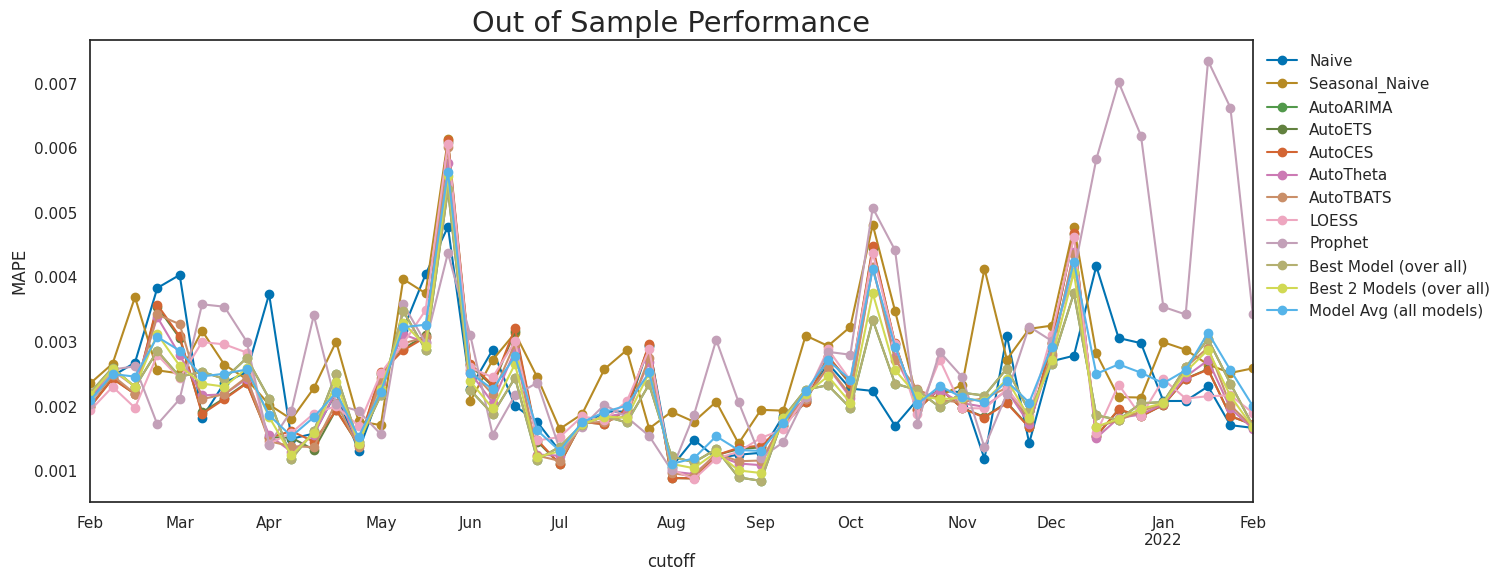

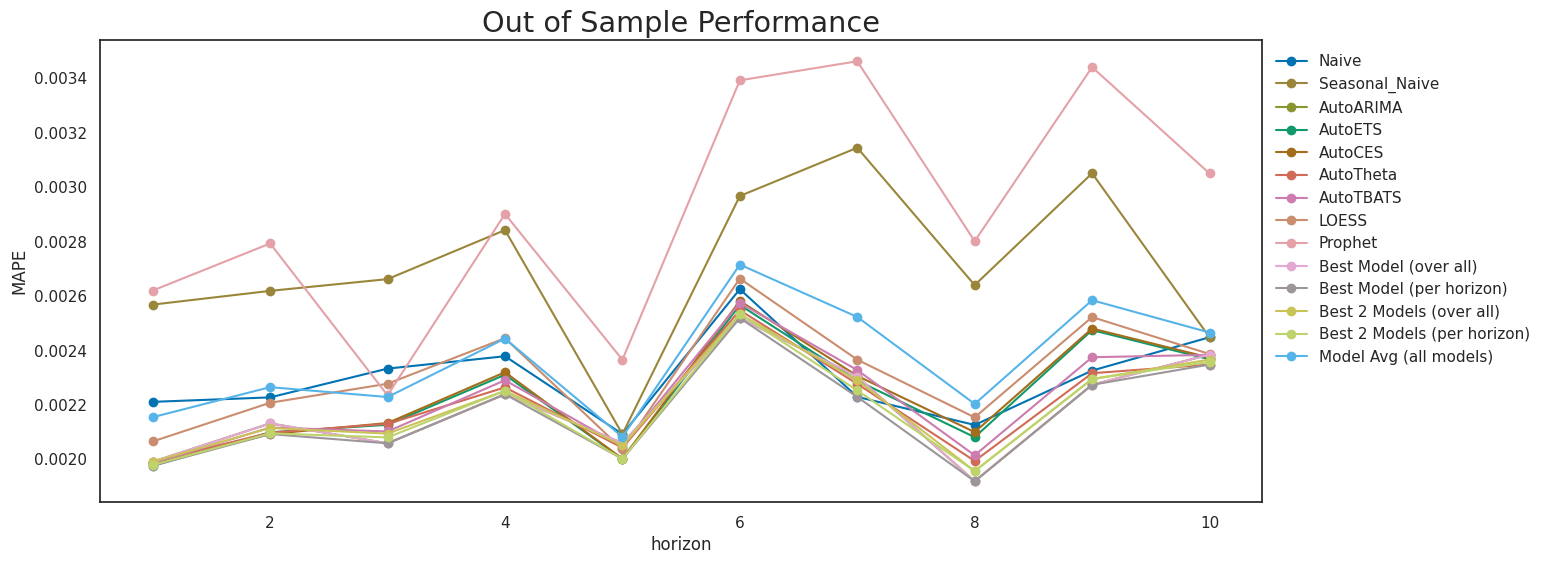

In [9]:
subset = ['AutoETS', 'AutoCES', 'AutoTBATS', 'Prophet','Model Avg (all models)']
model.plot_model_compare(score ='MAPE', view = 'cutoff')#, model_subset=subset)
model.plot_model_compare(score ='MAPE', view = 'horizon')#, model_subset=subset + ['Best Model (per horizon)'])

Fitting Naive ...
Fitting Seasonal_Naive ...
Fitting AutoARIMA ...
Fitting AutoETS ...
Fitting AutoCES ...
Fitting AutoTheta ...
Fitting AutoTBATS ...
Fitting LOESS ...


13:00:08 - cmdstanpy - INFO - Chain [1] start processing


Fitting Prophet ...


13:00:08 - cmdstanpy - INFO - Chain [1] done processing


LOESS does not support prediction intervals
Error: StatsForecastMSTL does not have the capability to return prediction intervals. If you think this estimator should have the capability, please open an issue on sktime.


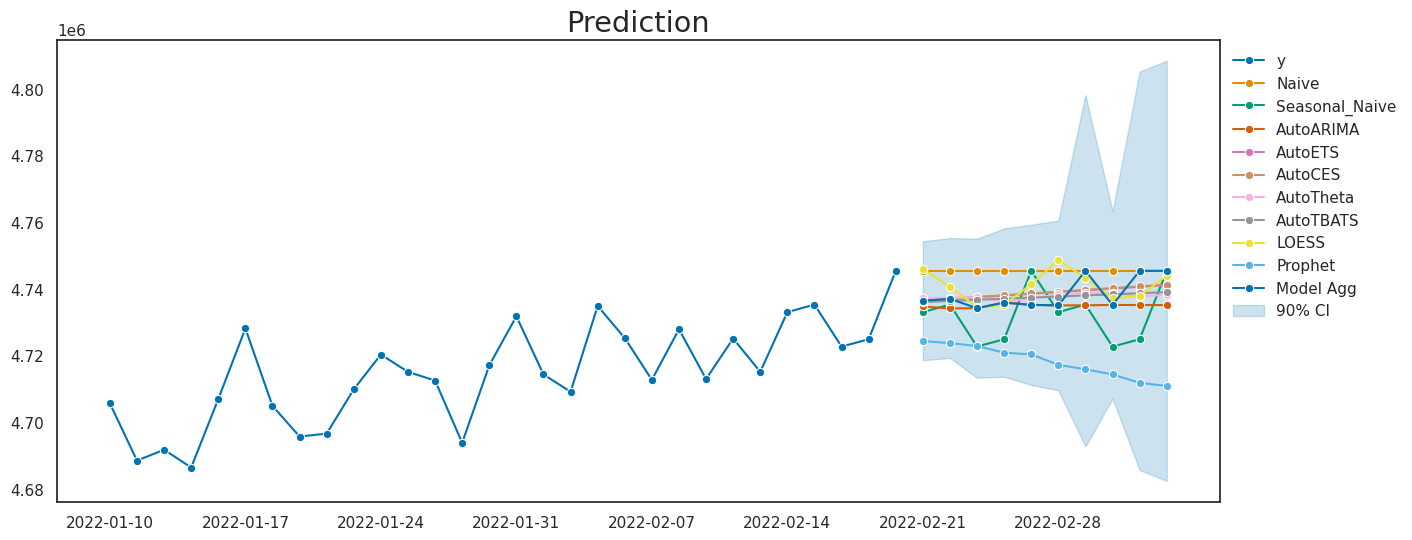

In [10]:
model.fit(verbose = True)
y_pred, y_pred_ints, preds, pred_ints = model.predict(mode='best_horizon', ret_underlying=True)
f, ax =model.plot_prediction(y_pred = y_pred,
                     models_preds = preds,
                     y_pred_interval = y_pred_ints)  

In [11]:
model.get_pred_errors()

100%|██████████| 1068/1068 [00:03<00:00, 311.78it/s]


,cutoff,horizon,error
0,2018-01-03,1,22474.50
1,2018-01-04,1,-5239.00
2,2018-01-05,1,319.50
3,2018-01-08,1,-25424.00
4,2018-01-09,1,8801.25
...,...,...,...
10675,2022-01-31,10,17910.00
10676,2022-02-01,10,2270.00
10677,2022-02-02,10,-12598.00
10678,2022-02-03,10,2191.00


In [12]:
path = '../model_output/NFA_forecast.pkl'
model.save(path)